## 1. Dependencies

In [46]:
import joblib
import json
import importlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import os
import pandas as pd
import sys
import tempfile

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# add the src directory to the path to import custom modules
sys.path.append('../src')

import clustering
import fine_tuning
importlib.reload(clustering)
importlib.reload(fine_tuning)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
from clustering import log_model_with_mlflow, interpret_participant_separated, get_cluster_station_gaps_context, get_cluster_station_gaps_only
from fine_tuning import add_instruction_tuning_columns

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
data_processed_folder = '../data/processed'
os.makedirs(data_processed_folder, exist_ok=True)

## 2. Load Standarized Dataset

In [5]:
filename = 'hyrox_clean_cluster_dataset.csv'
file_path = os.path.join(data_processed_folder, filename)
df = pd.read_csv(file_path)
print(f"Data shape: {df.shape}")

Data shape: (167743, 87)


## 3. Feature Scaling (Min-Max) for Model Training

I will apply Min-Max normalization to the dataset features in preparation for training regression models, as Min-Max preserves the distribution range needed for effective model learning and generalization.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167743 entries, 0 to 167742
Data columns (total 87 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    167743 non-null  object 
 1   event_name                            167743 non-null  object 
 2   gender                                167743 non-null  int64  
 3   age_min                               167638 non-null  float64
 4   age_max                               167638 non-null  float64
 5   total_time                            167743 non-null  float64
 6   work_time                             167743 non-null  float64
 7   roxzone_time                          167743 non-null  float64
 8   run_time                              167743 non-null  float64
 9   run_1                                 167743 non-null  float64
 10  1000m Ski                             167743 non-null  float64
 11  

Scale stations columns that will be used for training the model

In [7]:
# define stations columns
stations = df.columns[2:5].tolist() + df.columns[9:32].tolist()
stations_agg = df.columns[5:9].tolist()
print(f"Stations: {stations}")
print(f"Stations Agg: {stations_agg}")

Stations: ['gender', 'age_min', 'age_max', 'run_1', '1000m Ski', 'roxzone_1', 'run_2', '50m Sled Push', 'roxzone_2', 'run_3', '50m Sled Pull', 'roxzone_3', 'run_4', '80m Burpee Broad Jump', 'roxzone_4', 'run_5', '1000m Row', 'roxzone_5', 'run_6', '200m Farmer Carry', 'roxzone_6', 'run_7', '100m Sandbag Lunges', 'roxzone_7', 'run_8', '100 Wall Balls']
Stations Agg: ['total_time', 'work_time', 'roxzone_time', 'run_time']


In [8]:
# Min-Max normalization
minmaxScaler = MinMaxScaler()
df_minmax = pd.DataFrame(minmaxScaler.fit_transform(df[stations]), columns=stations)

# add normalized profile back to df
for col in stations:
    df[f'{col}_minmax'] = df_minmax[col]

In [9]:
filename = 'hyrox_minmax_scaler_stations.pkl'
file_path = os.path.join(data_processed_folder, filename)
joblib.dump(minmaxScaler, file_path)

['../data/processed/hyrox_minmax_scaler_stations.pkl']

In [11]:
# setup MLflow tracking
mlflow.end_run()
mlflow.set_experiment("hyrox-participant-modeling")
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [12]:
with mlflow.start_run(run_name="hyrox_minmax_scaler_stations"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_minmax_scaler_stations at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/cb0cec4897fe41c3bc34fec95a8d73ce
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


Scale the aggregated stations columns

In [13]:
df[stations_agg].head()

,total_time,work_time,roxzone_time,run_time
0,59.116667,25.516667,3.433333,30.166667
1,59.450000,25.100000,2.950000,31.400000
2,60.366667,26.066667,3.216667,31.083333
3,63.216667,27.483333,3.233333,32.500000
4,64.000000,29.016667,3.366667,31.616667


In [14]:
# Min-Max normalization
minmaxScalerAgg = MinMaxScaler()
df_minmax_agg = pd.DataFrame(minmaxScalerAgg.fit_transform(df[stations_agg]), columns=stations_agg)

# add normalized profile back to df
for col in stations_agg:
    df[f'{col}_minmax_agg'] = df_minmax_agg[col]

In [15]:
filename = 'hyrox_minmax_scaler_stations_agg.pkl'
file_path = os.path.join(data_processed_folder, filename)
joblib.dump(minmaxScaler, file_path)

['../data/processed/hyrox_minmax_scaler_stations_agg.pkl']

In [16]:
with mlflow.start_run(run_name="hyrox_minmax_scaler_agg"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_minmax_scaler_agg at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/0ba0cff816374c0ebd2749a3d1447227
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


In [17]:
with mlflow.start_run(run_name="hyrox_minmax_scaler_stations_agg"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_minmax_scaler_stations_agg at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/ec2295e85ded45529005f632b1d1d841
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


In [18]:
df.head(1)

,id,event_name,gender,age_min,age_max,total_time,work_time,roxzone_time,run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore,total_time_zscore_agg,work_time_zscore_agg,roxzone_time_zscore_agg,run_time_zscore_agg,gender_zscore_context,age_min_zscore_context,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context,cluster_perf_only,cluster_perf_context,gender_minmax,age_min_minmax,age_max_minmax,run_1_minmax,1000m Ski_minmax,roxzone_1_minmax,run_2_minmax,50m Sled Push_minmax,roxzone_2_minmax,run_3_minmax,50m Sled Pull_minmax,roxzone_3_minmax,run_4_minmax,80m Burpee Broad Jump_minmax,roxzone_4_minmax,run_5_minmax,1000m Row_minmax,roxzone_5_minmax,run_6_minmax,200m Farmer Carry_minmax,roxzone_6_minmax,run_7_minmax,100m Sandbag Lunges_minmax,roxzone_7_minmax,run_8_minmax,100 Wall Balls_minmax,total_time_minmax_agg,work_time_minmax_agg,roxzone_time_minmax_agg,run_time_minmax_agg
0,"111008_Diensthuber, Josef_GER",S6 2023 München,0,40.0,44.0,59.116667,25.516667,3.433333,30.166667,3.2,4.1,0.033333,3.6,2.116667,0.45,3.933333,3.333333,0.583333,3.85,3.3,0.65,3.8,4.216667,0.466667,3.833333,1.25,0.666667,3.783333,3.083333,0.583333,4.166667,4.116667,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,-0.95599,-0.868624,-1.15821,-0.884705,-0.696469,0.677415,0.682967,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,3,0,0.0,0.375,0.333333,0.067345,0.366617,0.001252,0.082759,0.039552,0.024635,0.10252,0.05772,0.020243,0.120942,0.07377,0.020822,0.088133,0.275599,0.015538,0.111922,0.041391,0.024922,0.085274,0.056248,0.010276,0.071043,0.07349,0.230609,0.19365,0.051968,0.202938


## 4. Feature Importance - Predict total time

The analysis of feature importance allows me to combine it with the clustering strategy, so that I can undertand, not only where a person has worst performance, but also how it impact the total time.

The approach is to train both a LinearRegression and a LightGBM and use the best model predictions to compute residuals.

In [19]:
# remove rows with NaN values in 'age_min' and 'age_max'
df.dropna(subset=['age_min', 'age_max'], inplace=True)
print(f"Data shape: {df.shape}")

Data shape: (167638, 117)


In [20]:
# scale gender, age_min and age_max
feature_cols = df.columns[61:87].tolist()
print(f"Stations: {feature_cols}")

Stations: ['age_max_zscore_context', 'run_1_zscore_context', '1000m Ski_zscore_context', 'roxzone_1_zscore_context', 'run_2_zscore_context', '50m Sled Push_zscore_context', 'roxzone_2_zscore_context', 'run_3_zscore_context', '50m Sled Pull_zscore_context', 'roxzone_3_zscore_context', 'run_4_zscore_context', '80m Burpee Broad Jump_zscore_context', 'roxzone_4_zscore_context', 'run_5_zscore_context', '1000m Row_zscore_context', 'roxzone_5_zscore_context', 'run_6_zscore_context', '200m Farmer Carry_zscore_context', 'roxzone_6_zscore_context', 'run_7_zscore_context', '100m Sandbag Lunges_zscore_context', 'roxzone_7_zscore_context', 'run_8_zscore_context', '100 Wall Balls_zscore_context', 'cluster_perf_only', 'cluster_perf_context']


In [21]:
X = df[feature_cols]

In [22]:
# target variable
y = df['total_time']

In [23]:
X.head(1)

,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context,cluster_perf_only,cluster_perf_context
0,0.682967,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,3,0


In [24]:
# target variablev in minutes
y.head(2)

0    59.116667
1    59.450000
Name: total_time, dtype: float64

In [25]:
print(X.shape, y.shape)

(167638, 26) (167638,)


In [26]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(X_train.shape, y_train.shape)

(134110, 26) (134110,)


### Linear Regression

In [28]:
log_model_with_mlflow(LinearRegression(), "LinearRegression", X_train, y_train, X_test, y_test)

/opt/anaconda3/envs/madenv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


✅ Logged LinearRegression with RMSE: 0.00 minutes and model signature.
🏃 View run LinearRegression_Hyrox at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/c140cdf573e043e1804104e936eb27cb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


> **Note**:
>
> Using only the performance + context breakdown (e.g., each run/work/roxzone z-score + age + gender), the model can estimate a participant total race time with an average error of about 1.5 minutes. This is a good level of accuracy considering race times typically range between 60–150 minutes.

### LightGBM

In [29]:
log_model_with_mlflow(LGBMRegressor(), "LightGBM", X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5870
[LightGBM] [Info] Number of data points in the train set: 134110, number of used features: 26
[LightGBM] [Info] Start training from score 86.041647


/opt/anaconda3/envs/madenv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


✅ Logged LightGBM with RMSE: 1.50 minutes and model signature.
🏃 View run LightGBM_Hyrox at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/8de3fb2c611346708423de9175847b88
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


## 5. Compute residuals

It's important to compute residuals based on the predicted time because it allows me to evaluate each competitor performance relative to what was expected for their age range and gender. Since the model was trained using both station times and contextual variables (age-gender), the predicted time reflects what similar participants typically achieve. 

By comparing the actual time to this personalized benchmark, I can detect whether someone outperformed or underperformed, not just in absolute terms, but relative to their expected potential. This adds a layer of fairness and insight when giving feedback.

In [31]:
# I picked the LGBMRegressor since the LinearRegression returns 0.0 for all predictions.
logged_model_uri = "runs:/8de3fb2c611346708423de9175847b88/model"
model = mlflow.sklearn.load_model(logged_model_uri)

In [33]:
feature_cols = X.columns.tolist()
print(f"Feature columns: {feature_cols}")

Feature columns: ['age_max_zscore_context', 'run_1_zscore_context', '1000m Ski_zscore_context', 'roxzone_1_zscore_context', 'run_2_zscore_context', '50m Sled Push_zscore_context', 'roxzone_2_zscore_context', 'run_3_zscore_context', '50m Sled Pull_zscore_context', 'roxzone_3_zscore_context', 'run_4_zscore_context', '80m Burpee Broad Jump_zscore_context', 'roxzone_4_zscore_context', 'run_5_zscore_context', '1000m Row_zscore_context', 'roxzone_5_zscore_context', 'run_6_zscore_context', '200m Farmer Carry_zscore_context', 'roxzone_6_zscore_context', 'run_7_zscore_context', '100m Sandbag Lunges_zscore_context', 'roxzone_7_zscore_context', 'run_8_zscore_context', '100 Wall Balls_zscore_context', 'cluster_perf_only', 'cluster_perf_context']


In [34]:
# insert predicted_total_time at index 5
df.insert(5, 'predicted_total_time', model.predict(df[feature_cols]))

# insert residual at index 6 (after predicted_total_time)
df.insert(6, 'residual', df['total_time'] - df['predicted_total_time'])

**Residual Value → Interpretation**

positive → 🟥 Slower than expected → underperformed

negative → 🟩 Faster than expected → outperformed

≈ 0 → 🟨 Performed close to prediction


In [35]:
df[['gender', 'age_min', 'age_max', 'total_time', 'predicted_total_time', 'residual']].head(5)

,gender,age_min,age_max,total_time,predicted_total_time,residual
0,0,40.0,44.0,59.116667,59.781600,-0.664934
1,0,25.0,29.0,59.450000,61.491771,-2.041771
2,0,30.0,34.0,60.366667,60.652530,-0.285863
3,0,30.0,34.0,63.216667,63.095683,0.120984
4,0,30.0,34.0,64.000000,65.381887,-1.381887


## 6. Compare Participants with both cluster profiles (performance only and performance + context)

**Load the cluster dataframes**

In [36]:
# get the cluster profiles only by performance
file_path = os.path.join(data_processed_folder, 'hyrox_cluster_profiles_perf_only.csv')
df_clusters_perf_only = pd.read_csv(file_path)

# # get the cluster profiles by performance + context
file_path = os.path.join(data_processed_folder, 'hyrox_cluster_profiles_perf_context.csv')
df_clusters_perf_context = pd.read_csv(file_path)

In [37]:
df_clusters_perf_only

,cluster_perf_only,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore
0,0,0.343096,0.343654,0.232057,0.361066,0.302542,0.304373,0.351429,0.369658,0.322624,0.354225,0.348031,0.265346,0.341750,0.356781,0.327046,0.349106,0.357156,0.347020,0.341962,0.315129,0.290476,0.296208,0.292082
1,1,-2.703767,-3.545248,-1.722484,-2.954812,-2.406252,-1.779475,-2.905123,-2.436241,-1.821764,-2.924998,-2.164719,-1.316754,-2.835454,-3.518605,-1.803928,-2.895063,-2.645421,-1.922204,-2.870626,-2.337466,-1.617520,-2.422084,-2.109076
2,2,0.871888,0.661795,0.829537,1.128353,0.961610,1.225136,1.213530,1.185937,1.224524,1.259999,1.393979,0.998671,1.322992,0.785496,1.142525,1.291339,1.046598,1.103484,1.302424,1.341110,1.251395,1.491315,1.202704
3,3,-0.139433,0.032873,-0.171082,-0.185620,-0.169512,-0.327372,-0.206259,-0.280992,-0.336999,-0.217842,-0.354224,-0.300595,-0.235936,-0.014083,-0.322201,-0.225722,-0.204807,-0.312698,-0.225860,-0.287855,-0.344985,-0.298300,-0.264512


In [38]:
df_clusters_perf_context

,cluster_perf_context,gender_zscore_context,age_min_zscore_context,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context
0,0,-0.201045,-0.198697,-0.205402,-0.153354,0.014561,-0.177637,-0.197193,-0.170338,-0.325866,-0.212484,-0.294414,-0.337305,-0.226064,-0.369538,-0.296074,-0.242376,-0.029027,-0.320559,-0.235008,-0.206701,-0.307988,-0.235708,-0.294337,-0.339107,-0.303093,-0.258703
1,1,0.010893,-0.089325,-0.083161,-2.703765,-3.545247,-1.722484,-2.954811,-2.406252,-1.779475,-2.905123,-2.436241,-1.821764,-2.924998,-2.164719,-1.316754,-2.835454,-3.518605,-1.803928,-2.895063,-2.645421,-1.922204,-2.870626,-2.337466,-1.617520,-2.422084,-2.109075
2,2,0.154636,0.212318,0.223117,0.860107,0.652821,0.815692,1.104364,0.949186,1.202781,1.185580,1.163944,1.206267,1.231745,1.368604,0.988519,1.293610,0.774717,1.129826,1.262297,1.030691,1.092087,1.273332,1.315811,1.236411,1.457619,1.183662
3,3,0.172350,0.167923,0.171004,0.337778,0.351235,0.220960,0.350954,0.280933,0.274013,0.334939,0.356768,0.292458,0.338856,0.333379,0.233358,0.323389,0.357451,0.294985,0.334583,0.334406,0.311312,0.328009,0.294500,0.252653,0.273752,0.258999


In [39]:
stations_zscore_cols = df_clusters_perf_context.columns[1:24].tolist()
print(f"Stations Z-score columns: {stations_zscore_cols}")

Stations Z-score columns: ['gender_zscore_context', 'age_min_zscore_context', 'age_max_zscore_context', 'run_1_zscore_context', '1000m Ski_zscore_context', 'roxzone_1_zscore_context', 'run_2_zscore_context', '50m Sled Push_zscore_context', 'roxzone_2_zscore_context', 'run_3_zscore_context', '50m Sled Pull_zscore_context', 'roxzone_3_zscore_context', 'run_4_zscore_context', '80m Burpee Broad Jump_zscore_context', 'roxzone_4_zscore_context', 'run_5_zscore_context', '1000m Row_zscore_context', 'roxzone_5_zscore_context', 'run_6_zscore_context', '200m Farmer Carry_zscore_context', 'roxzone_6_zscore_context', 'run_7_zscore_context', '100m Sandbag Lunges_zscore_context']


In [40]:
print(f"df shape: {df.shape}")

df shape: (167638, 119)


In [41]:
df.head(1)

,id,event_name,gender,age_min,age_max,predicted_total_time,residual,total_time,work_time,roxzone_time,run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore,total_time_zscore_agg,work_time_zscore_agg,roxzone_time_zscore_agg,run_time_zscore_agg,gender_zscore_context,age_min_zscore_context,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context,cluster_perf_only,cluster_perf_context,gender_minmax,age_min_minmax,age_max_minmax,run_1_minmax,1000m Ski_minmax,roxzone_1_minmax,run_2_minmax,50m Sled Push_minmax,roxzone_2_minmax,run_3_minmax,50m Sled Pull_minmax,roxzone_3_minmax,run_4_minmax,80m Burpee Broad Jump_minmax,roxzone_4_minmax,run_5_minmax,1000m Row_minmax,roxzone_5_minmax,run_6_minmax,200m Farmer Carry_minmax,roxzone_6_minmax,run_7_minmax,100m Sandbag Lunges_minmax,roxzone_7_minmax,run_8_minmax,100 Wall Balls_minmax,total_time_minmax_agg,work_time_minmax_agg,roxzone_time_minmax_agg,run_time_minmax_agg
0,"111008_Diensthuber, Josef_GER",S6 2023 München,0,40.0,44.0,59.7816,-0.664934,59.116667,25.516667,3.433333,30.166667,3.2,4.1,0.033333,3.6,2.116667,0.45,3.933333,3.333333,0.583333,3.85,3.3,0.65,3.8,4.216667,0.466667,3.833333,1.25,0.666667,3.783333,3.083333,0.583333,4.166667,4.116667,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,-0.95599,-0.868624,-1.15821,-0.884705,-0.696469,0.677415,0.682967,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,3,0,0.0,0.375,0.333333,0.067345,0.366617,0.001252,0.082759,0.039552,0.024635,0.10252,0.05772,0.020243,0.120942,0.07377,0.020822,0.088133,0.275599,0.015538,0.111922,0.041391,0.024922,0.085274,0.056248,0.010276,0.071043,0.07349,0.230609,0.19365,0.051968,0.202938


In [42]:
df[['id', 'event_name', 'age_min', 'age_max', 'gender']].duplicated().sum()

1106

In [43]:
df = df.drop_duplicates(subset=['id', 'event_name', 'age_min', 'age_max', 'gender'], keep='first')
df = df.drop_duplicates(subset=['id', 'event_name', 'age_min', 'age_max'], keep='first')
df = df.drop_duplicates(subset=['id', 'event_name', 'age_min'], keep='first')
df = df.drop_duplicates(subset=['id', 'event_name'], keep='first')

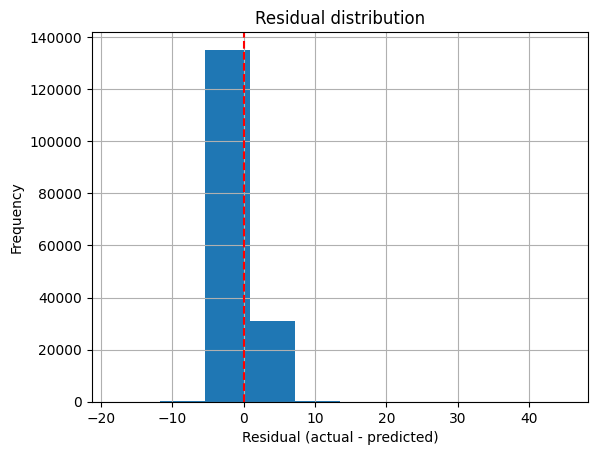

<Figure size 640x480 with 0 Axes>

🏃 View run residual_distribution at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/ead58c4126a4428695fbd84a339cf43b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


In [44]:
with mlflow.start_run(run_name="residual_distribution"):

    df['residual'].hist(bins=10)
    plt.title("Residual distribution")
    plt.xlabel("Residual (actual - predicted)")
    plt.ylabel("Frequency")
    plt.axvline(0, color='red', linestyle='--')
    plt.show()
    
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        mlflow.log_artifact(tmp.name, artifact_path="figures")

    plt.show()
    plt.close()
    
mlflow.end_run()


In [48]:
low_thresh = df['residual'].quantile(0.10)
high_thresh = df['residual'].quantile(0.90)
thresholds = {
    "low_thresh": low_thresh,
    "high_thresh": high_thresh
}
print(f"Low threshold: {low_thresh}, High threshold: {high_thresh}")

Low threshold: -1.3744863312640376, High threshold: 1.3450602867290797


In [49]:
filename = 'hyrox_thresholds.json'
file_path = os.path.join(data_processed_folder, filename)
with open(file_path, "w") as f:
    json.dump(thresholds, f)

with mlflow.start_run(run_name="hyrox_thresholds"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_thresholds at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/b6b2e9874c7444a0873b65316629cacf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697


In [50]:
df["suggestions_perf_only"] = df.apply(
    lambda row: get_cluster_station_gaps_only(row, df_clusters_perf_only, stations_zscore_cols),
    axis=1
)

df["suggestions_perf_context"] = df.apply(
    lambda row: get_cluster_station_gaps_context(row, df_clusters_perf_context, stations_zscore_cols),
    axis=1
)

df["performance_feedback"] = df.apply(
    lambda row: interpret_participant_separated(row, df_clusters_perf_only, df_clusters_perf_context, stations_zscore_cols, low_thresh, high_thresh),
    axis=1
)

In [51]:
df.shape

(166521, 122)

In [61]:
df[['id', 'suggestions_perf_only', 'suggestions_perf_context', 'performance_feedback']].head(10)

,id,suggestions_perf_only,suggestions_perf_context,performance_feedback
0,"111008_Diensthuber, Josef_GER",[],"[age_min_context, age_max_context]","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: age_min_context, age_max_context."
1,"112005_Groinig, Rene_AUT",[],[],You performed better than expected based on your overall predicted time.
2,"123024_Stejskal, Tomáš_CZE",[],[],You performed close to expected levels.
3,"115015_Oldach, Maik_GER",[],[],You performed close to expected levels.
4,"104030_Scheffel, Steve_GER",[],[],You performed better than expected based on your overall predicted time.
5,"93021_Guillaume, Siber_FRA",[],[],You performed close to expected levels.
6,"95005_Schwengers, Patrick_GER",[],[roxzone_6_context],"You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: roxzone_6_context."
7,"93001_Bartsch, Michael_GER",[],[50m Sled Push_context],"You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: 50m Sled Push_context."
8,"115023_Pötzelsber, Laurenz_AUT",[],"[age_min_context, age_max_context, roxzone_4_context]","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: age_min_context, age_max_context, roxzone_4_context."
9,"115007_Müller, Reto_SUI",[],"[age_min_context, age_max_context, 50m Sled Push_context]","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: age_min_context, age_max_context, 50m Sled Push_context."


## 7. Prepare Dataset for Instruction Tuning

In [ ]:
def build_prompt(row):
    return f"""### Instruction:
    {row['input']}

    ### Context:
    {row['context']}

    ### Response:
    {row['response']}"""

df["text"] = df.apply(build_prompt, axis=1)

In [53]:
df = add_instruction_tuning_columns(df)

In [63]:
df[[
    'gender', 'age_min', 'age_max', 'total_time',
    'predicted_total_time', 'residual', 'performance_feedback',
    'input', 'context', 'response', 'text'
]].tail(5)

,gender,age_min,age_max,total_time,predicted_total_time,residual,performance_feedback,input,context,response,text
167738,1,45.0,49.0,108.066667,107.939685,0.126982,"You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, run_1_context, 1000m Ski_context, run_2_context, roxzone_2_context, run_3_context, run_4_context, 80m Burpee Broad Jump_context, roxzone_4_context, run_5_context, 1000m Row_context, run_6_context, run_7_context.",What would you tell this HYROX Open athlete based on their data?,"gender: 1, age_range: 45.0-49.0, total_time: 108, predicted_time: 108, residual: 0, cluster_perf_only: 0, cluster_perf_context: 3","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, run_1_context, 1000m Ski_context, run_2_context, roxzone_2_context, run_3_context, run_4_context, 80m Burpee Broad Jump_context, roxzone_4_context, run_5_context, 1000m Row_context, run_6_context, run_7_context.","### Instruction:\n What would you tell this HYROX Open athlete based on their data?\n\n ### Context:\n gender: 1, age_range: 45.0-49.0, total_time: 108, predicted_time: 108, residual: 0, cluster_perf_only: 0, cluster_perf_context: 3\n\n ### Response:\n You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, run_1_context, 1000m Ski_context, run_2_context, roxzone_2_context, run_3_context, run_4_context, 80m Burpee Broad Jump_context, roxzone_4_context, run_5_context, 1000m Row_context, run_6_context, run_7_context."
167739,1,45.0,49.0,112.216667,112.878424,-0.661757,"You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, 1000m Ski_context, 1000m Row_context.",Generate personalized feedback for a HYROX Open Division participant based on their performance.,"gender: 1, age_range: 45.0-49.0, total_time: 112, predicted_time: 113, residual: -1, cluster_perf_only: 0, cluster_perf_context: 2","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, 1000m Ski_context, 1000m Row_context.","### Instruction:\n Generate personalized feedback for a HYROX Open Division participant based on their performance.\n\n ### Context:\n gender: 1, age_range: 45.0-49.0, total_time: 112, predicted_time: 113, residual: -1, cluster_perf_only: 0, cluster_perf_context: 2\n\n ### Response:\n You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, 1000m Ski_context, 1000m Row_context."
167740,1,40.0,44.0,114.500000,114.397350,0.102650,"You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, roxzone_2_context, roxzone_3_context, roxzone_4_context, roxzone_5_context.",Explain this HYROX Open Division participant's performance using their residual and cluster data.,"gender: 1, age_range: 40.0-44.0, total_time: 114, predicted_time: 114, residual: 0, cluster_perf_only: 2, cluster_perf_context: 2","You performed close to expected levels. Compared to athletes of similar age and gender, your weak areas were: gender_context, age_min_context, age_max_context, roxzone_2_context, roxzone_3_context, roxzone_4_context, roxzone_5_context.","### Instruction:\n Explain this HYROX Open Division participant's performance using their residual and cluster data.\n\n ### Context:\n gender: 1, age_range: 40.0-44.0, total_time: 114, predicted_time: 114, residual: 0, cluster_perf_only: 2, cluster_perf_context: 2\n\n ### Response:\n You performed close to expected levels. Compared to at

In [64]:
df.shape

(166521, 126)

In [65]:
filename = 'hyrox_full_data_instructed_feedback.csv'
file_path = os.path.join(data_processed_folder, filename)
df.to_csv(file_path, index=False)

In [67]:
# save it also in format better for LLM fine-tuning
filename = 'hyrox_full_data_instructed_feedback.jsonl'
file_path = os.path.join(data_processed_folder, filename)
df[["input", "context", "response", "text"]].to_json(file_path, orient="records", lines=True)

with mlflow.start_run(run_name="hyrox_full_data_instructed_feedback-jsonl"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_full_data_instructed_feedback-jsonl at: http://127.0.0.1:8080/#/experiments/680043381743336697/runs/4ec3e1ad38704c379d1349fc74fb470d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/680043381743336697
